# Experimental Results for Semantic Chunking

## Prep

In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd

metrics = ["NDCG@k", "MAP@k", "Recall@k", "Precision@k", "MRR@k", "R_cap@k", "Hole@k", "Accuracy@k"]
datasets = ['nfcorpus','nq','hotpotqa','fiqa', 'webis-touche2020','dbpedia-entity','scidocs','fever','climate-fever','scifact']#,'mldr']
k_values = [1,5]

def get_important_metrics(metrics: list):
    important_metrics = []
    for metric in metrics:
        if metric == "Precision@k":
            for k in k_values:
                important_metrics.append(f'P@{str(k)}')
        elif metric[:4] != 'Hole':
            for k in k_values:
                important_metrics.append(metric.replace('k',str(k)))
    return important_metrics

important_metrics = get_important_metrics(metrics)

In [2]:
def get_results_df(dataset: str):
    results = []
    with open(f"results/results.jsonl",'r') as f:
        for line in f:
            result = json.loads(line)
            if result['dataset'] == dataset:
                results.append(result)

    df = pd.DataFrame(results)
    for metric in metrics:
        df = pd.concat([df, df[metric].apply(pd.Series)], axis=1)
        df.drop(metric, axis=1, inplace=True)

    return df

def get_average_results():
    dfs = []
    for dataset in datasets:
        df = get_results_df(dataset).drop('dataset', axis=1)
        df['hyperparams'] = df['hyperparams'].astype(str)
        dfs.append(df)
    return pd.concat(dfs).groupby(by=['encoder', 'chunker', 'hyperparams']).mean().reset_index()

def get_best_config_per_chunker(df, chunker):
    df_sub = df[df['chunker']==chunker][important_metrics]
    return df_sub.index[df_sub.mean(axis=1).argmax()]

def get_best_configs(df):
    idxs = [get_best_config_per_chunker(df, chunker) for chunker in df['chunker'].unique()]
    return df.loc[idxs, ['encoder', 'chunker', 'hyperparams', 'Latency']+important_metrics]

def get_hyperparam_comparison(df, hyperparam, default_method = None, exclude_methods = []):
    """Get the evaluation results for the hyperparameter comparison.

    Args:
        df (pd.DataFrame): the evaluation results
        hyperparam (str): the hyperparameter to compare
        default_method (str): the default method to include in comparison
        exclude_methods (list): the methods to exclude from comparison

    Returns:
        pd.DataFrame: the evaluation results for the hyperparameter comparison
    """
    idxs = [idx for idx in df.index if hyperparam in idx or (default_method and idx == default_method)]
    if exclude_methods: idxs = [idx for idx in idxs if idx not in exclude_methods]
    return df.loc[idxs, important_metrics].sort_index()

def plot_metrics_cross_all_k(df, xargs = ['0', '0.25', '0.5', '0.75'], xlabel = 'lamda'):
    """Plot the evaluation results per metric across all k for the selected hyperparameter.

    Args:
        df (pd.DataFrame): the evaluation results
        xargs (list): the values for the hyperparameter
        xlabel (str): the label for the x-axis (the hyperparameter)
    """
    plot_metrics = ["NDCG", "MAP", "Recall", "P", "MRR", "R_cap", "Accuracy"]
    xticks = range(1,len(xargs)+1)
    for plot_metric in plot_metrics:
        cols = [column for column in df.columns if plot_metric in column]
        plt.plot(xticks, df[cols].mean(axis=1).tolist(), label=plot_metric)
    plt.xticks(xticks, xargs)
    # plt.yticks(yticks, yticks)
    plt.xlabel(xlabel)
    plt.ylabel('score')
    plt.legend()
    plt.show()

## Overall

In [3]:
get_results_df('mldr').sort_values('NDCG@3', ascending=False).head(10)

,Latency,dataset,encoder,chunker,hyperparams,NDCG@1,NDCG@3,NDCG@5,NDCG@10,NDCG@20,...,Hole@1,Hole@3,Hole@5,Hole@10,Hole@20,Accuracy@1,Accuracy@3,Accuracy@5,Accuracy@10,Accuracy@20
51,156.117858,mldr,openai,cluster_chunker,"{'lamda': 0.75, 'max_samples_per_cluster': 1}",0.98,0.98631,0.98631,0.98631,0.98631,...,0.0,0.22667,0.278,0.332,0.3640,0.98,0.99,0.99,0.99,0.99
55,147.751057,mldr,openai,cluster_chunker,"{'lamda': 1, 'max_samples_per_cluster': None}",0.98,0.98631,0.98631,0.98631,0.98631,...,0.0,0.22667,0.278,0.334,0.3650,0.98,0.99,0.99,0.99,0.99
41,153.869322,mldr,openai,cluster_chunker,"{'lamda': 0.25, 'max_samples_per_cluster': 1}",0.98,0.98631,0.98631,0.98631,0.98631,...,0.0,0.23000,0.278,0.334,0.3640,0.98,0.99,0.99,0.99,0.99
46,145.601407,mldr,openai,cluster_chunker,"{'lamda': 0.5, 'max_samples_per_cluster': 1}",0.98,0.98631,0.98631,0.98631,0.98631,...,0.0,0.22667,0.280,0.333,0.3650,0.98,0.99,0.99,0.99,0.99
58,140.944370,mldr,openai,cluster_chunker,"{'lamda': 1, 'max_samples_per_cluster': 5}",0.98,0.98631,0.98631,0.98631,0.98631,...,0.0,0.22667,0.278,0.332,0.3630,0.98,0.99,0.99,0.99,0.99
57,138.242167,mldr,openai,cluster_chunker,"{'lamda': 1, 'max_samples_per_cluster': 3}",0.98,0.98631,0.98631,0.98631,0.98631,...,0.0,0.22667,0.278,0.333,0.3640,0.98,0.99,0.99,0.99,0.99
56,145.807534,mldr,openai,cluster_chunker,"{'lamda': 1, 'max_samples_per_cluster': 1}",0.98,0.98631,0.98631,0.98631,0.98631,...,0.0,0.22667,0.280,0.334,0.3640,0.98,0.99,0.99,0.99,0.99
36,140.143627,mldr,openai,cluster_chunker,"{'lamda': 0, 'max_samples_per_cluster': 1}",0.98,0.98631,0.98631,0.98631,0.98631,...,0.0,0.22667,0.278,0.333,0.3640,0.98,0.99,0.99,0.99,0.99
59,138.887108,mldr,openai,cluster_chunker,"{'lamda': 1, 'max_samples_per_cluster': 10}",0.98,0.98631,0.98631,0.98631,0.98631,...,0.0,0.22667,0.278,0.333,0.3645,0.98,0.99,0.99,0.99,0.99
65,179.314080,mldr,openai,sentence_chunker,{'sentence_chunker_k': 1},0.98,0.98500,0.98500,0.98500,0.98500,...,0.0,0.21333,0.266,0.314,0.3325,0.98,0.99,0.99,0.99,0.99


Averaged across all datasets.

In [25]:
df = get_average_results()
get_best_configs(df)

,encoder,chunker,hyperparams,Latency,NDCG@1,NDCG@5,MAP@1,MAP@5,Recall@1,Recall@5,P@1,P@5,MRR@1,MRR@5,R_cap@1,R_cap@5,Accuracy@1,Accuracy@5
39,openai,cluster_chunker,"{'lamda': 0, 'max_samples_per_cluster': None}",85.978585,0.781359,0.743084,0.414554,0.582578,0.414554,0.626517,0.801298,0.394421,0.801607,0.853442,0.801607,0.754543,0.801607,0.933090
63,openai,langchain_chunker,"{'breakpoint_threshold_type': 'percentile', 'b...",146.283466,0.722126,0.697054,0.402003,0.556436,0.402003,0.608582,0.745477,0.361265,0.748137,0.814114,0.748137,0.718667,0.748137,0.921068
66,openai,sentence_chunker,{'sentence_chunker_k': 3},98.279066,0.751424,0.730704,0.410425,0.574073,0.410425,0.623717,0.771462,0.389535,0.772081,0.835110,0.772081,0.750901,0.772081,0.927438
33,huggingface,whole_chunker,{},3.925938,0.340644,0.305607,0.137394,0.192844,0.137394,0.250736,0.355874,0.184979,0.355874,0.427165,0.355874,0.328587,0.355874,0.547866
69,openai,word_chunker,{'word_chunker_k': 10},196.721580,0.700852,0.681572,0.387218,0.535464,0.387218,0.593039,0.719157,0.355426,0.719157,0.790440,0.719157,0.706939,0.719157,0.901123


In [7]:
df[df['chunker']=='sentence_chunker'].sort_values(by='NDCG@1', ascending=False)[:10]

,encoder,chunker,hyperparams,Latency,NDCG@1,NDCG@3,NDCG@5,NDCG@10,NDCG@20,MAP@1,...,Hole@1,Hole@3,Hole@5,Hole@10,Hole@20,Accuracy@1,Accuracy@3,Accuracy@5,Accuracy@10,Accuracy@20
67,openai,sentence_chunker,{'sentence_chunker_k': 5},88.844985,0.755549,0.722711,0.721072,0.735745,0.755043,0.403186,...,0.012000,0.013133,0.014728,0.022000,0.027673,0.773258,0.892317,0.922509,0.956120,0.976997
66,openai,sentence_chunker,{'sentence_chunker_k': 3},98.279066,0.751424,0.729878,0.730704,0.745171,0.762048,0.410425,...,0.010000,0.014095,0.017336,0.023441,0.027011,0.772081,0.897202,0.927438,0.959849,0.974526
65,openai,sentence_chunker,{'sentence_chunker_k': 1},148.055326,0.720989,0.696958,0.697263,0.718004,0.743073,0.401950,...,0.012082,0.017441,0.019929,0.022845,0.027866,0.748877,0.878416,0.913320,0.956572,0.977307
32,huggingface,sentence_chunker,{'sentence_chunker_k': 5},11.734571,0.692769,0.663387,0.665060,0.678620,0.698657,0.369366,...,0.014000,0.020067,0.021720,0.023456,0.027819,0.709033,0.857487,0.895550,0.933219,0.962263
31,huggingface,sentence_chunker,{'sentence_chunker_k': 3},12.312603,0.691120,0.665372,0.667505,0.684977,0.706243,0.378642,...,0.015041,0.017880,0.021784,0.024509,0.026757,0.709904,0.856514,0.895709,0.939728,0.966463
30,huggingface,sentence_chunker,{'sentence_chunker_k': 1},15.185057,0.660757,0.643012,0.647133,0.666107,0.691244,0.369950,...,0.015082,0.021241,0.021289,0.025125,0.028931,0.683472,0.836159,0.886685,0.936638,0.970230


# Method Comparison

k-preserve: min_samples = 1,2,4,6

In [ ]:
{"NDCG@k": {"NDCG@1": 0.49, "NDCG@3": 0.56905, "NDCG@5": 0.58807, "NDCG@10": 0.60734, "NDCG@100": 0.64002, "NDCG@1000": 0.64795}, "MAP@k": {"MAP@1": 0.49, "MAP@3": 0.55, "MAP@5": 0.5606, "MAP@10": 0.56847, "MAP@100": 0.57524, "MAP@1000": 0.57553}, "Recall@k": {"Recall@1": 0.49, "Recall@3": 0.624, "Recall@5": 0.67, "Recall@10": 0.73, "Recall@100": 0.884, "Recall@1000": 0.946}, "Precision@k": {"P@1": 0.49, "P@3": 0.208, "P@5": 0.134, "P@10": 0.073, "P@100": 0.00884, "P@1000": 0.00095}, "MRR@k": {"MRR@1": 0.49, "MRR@3": 0.55, "MRR@5": 0.5606, "MRR@10": 0.56847, "MRR@100": 0.57524, "MRR@1000": 0.57553}, "R_cap@k": {"R_cap@1": 0.49, "R_cap@3": 0.624, "R_cap@5": 0.67, "R_cap@10": 0.73, "R_cap@100": 0.884, "R_cap@1000": 0.946}, "Hole@k": {"Hole@1": 0.25, "Hole@3": 0.37733, "Hole@5": 0.4196, "Hole@10": 0.4504, "Hole@100": 0.48606, "Hole@1000": 0.25687}, "Accuracy@k": {"Accuracy@1": 0.49, "Accuracy@3": 0.624, "Accuracy@5": 0.67, "Accuracy@10": 0.73, "Accuracy@100": 0.884, "Accuracy@1000": 0.946}, "Latency": 222.20034337043762}
{"NDCG@k": {"NDCG@1": 0.7, "NDCG@3": 0.75038, "NDCG@5": 0.76355, "NDCG@10": 0.77433, "NDCG@100": 0.79498, "NDCG@1000": 0.79829}, "MAP@k": {"MAP@1": 0.7, "MAP@3": 0.73867, "MAP@5": 0.74597, "MAP@10": 0.75029, "MAP@100": 0.75461, "MAP@1000": 0.75477}, "Recall@k": {"Recall@1": 0.7, "Recall@3": 0.784, "Recall@5": 0.816, "Recall@10": 0.85, "Recall@100": 0.946, "Recall@1000": 0.97}, "Precision@k": {"P@1": 0.7, "P@3": 0.26133, "P@5": 0.1632, "P@10": 0.085, "P@100": 0.00946, "P@1000": 0.00097}, "MRR@k": {"MRR@1": 0.7, "MRR@3": 0.73867, "MRR@5": 0.74597, "MRR@10": 0.75029, "MRR@100": 0.75461, "MRR@1000": 0.75477}, "R_cap@k": {"R_cap@1": 0.7, "R_cap@3": 0.784, "R_cap@5": 0.816, "R_cap@10": 0.85, "R_cap@100": 0.946, "R_cap@1000": 0.97}, "Hole@k": {"Hole@1": 0.084, "Hole@3": 0.20267, "Hole@5": 0.2312, "Hole@10": 0.257, "Hole@100": 0.30262, "Hole@1000": 0.11654}, "Accuracy@k": {"Accuracy@1": 0.7, "Accuracy@3": 0.784, "Accuracy@5": 0.816, "Accuracy@10": 0.85, "Accuracy@100": 0.946, "Accuracy@1000": 0.97}, "Latency": 720.4304809570312}
{"NDCG@k": {"NDCG@1": 0.664, "NDCG@3": 0.72643, "NDCG@5": 0.74019, "NDCG@10": 0.75607, "NDCG@100": 0.77502, "NDCG@1000": 0.77873}, "MAP@k": {"MAP@1": 0.664, "MAP@3": 0.71133, "MAP@5": 0.71883, "MAP@10": 0.72559, "MAP@100": 0.72932, "MAP@1000": 0.72948}, "Recall@k": {"Recall@1": 0.664, "Recall@3": 0.77, "Recall@5": 0.804, "Recall@10": 0.852, "Recall@100": 0.942, "Recall@1000": 0.97}, "Precision@k": {"P@1": 0.664, "P@3": 0.25667, "P@5": 0.1608, "P@10": 0.0852, "P@100": 0.00942, "P@1000": 0.00097}, "MRR@k": {"MRR@1": 0.664, "MRR@3": 0.71133, "MRR@5": 0.71883, "MRR@10": 0.72559, "MRR@100": 0.72932, "MRR@1000": 0.72948}, "R_cap@k": {"R_cap@1": 0.664, "R_cap@3": 0.77, "R_cap@5": 0.804, "R_cap@10": 0.852, "R_cap@100": 0.942, "R_cap@1000": 0.97}, "Hole@k": {"Hole@1": 0.082, "Hole@3": 0.18533, "Hole@5": 0.2052, "Hole@10": 0.2374, "Hole@100": 0.288, "Hole@1000": 0.10652}, "Accuracy@k": {"Accuracy@1": 0.664, "Accuracy@3": 0.77, "Accuracy@5": 0.804, "Accuracy@10": 0.852, "Accuracy@100": 0.942, "Accuracy@1000": 0.97}, "Latency": 698.1945724487305}
{"NDCG@k": {"NDCG@1": 0.604, "NDCG@3": 0.68226, "NDCG@5": 0.70559, "NDCG@10": 0.71681, "NDCG@100": 0.73731, "NDCG@1000": 0.74219}, "MAP@k": {"MAP@1": 0.604, "MAP@3": 0.663, "MAP@5": 0.6761, "MAP@10": 0.68086, "MAP@100": 0.68509, "MAP@1000": 0.68531}, "Recall@k": {"Recall@1": 0.604, "Recall@3": 0.738, "Recall@5": 0.794, "Recall@10": 0.828, "Recall@100": 0.924, "Recall@1000": 0.96}, "Precision@k": {"P@1": 0.604, "P@3": 0.246, "P@5": 0.1588, "P@10": 0.0828, "P@100": 0.00924, "P@1000": 0.00096}, "MRR@k": {"MRR@1": 0.604, "MRR@3": 0.663, "MRR@5": 0.6761, "MRR@10": 0.68086, "MRR@100": 0.68509, "MRR@1000": 0.68531}, "R_cap@k": {"R_cap@1": 0.604, "R_cap@3": 0.738, "R_cap@5": 0.794, "R_cap@10": 0.828, "R_cap@100": 0.924, "R_cap@1000": 0.96}, "Hole@k": {"Hole@1": 0.092, "Hole@3": 0.196, "Hole@5": 0.2088, "Hole@10": 0.2328, "Hole@100": 0.2811, "Hole@1000": 0.10585}, "Accuracy@k": {"Accuracy@1": 0.604, "Accuracy@3": 0.738, "Accuracy@5": 0.794, "Accuracy@10": 0.828, "Accuracy@100": 0.924, "Accuracy@1000": 0.96}, "Latency": 622.7630252838135}

sentence: k=1,3,5

In [ ]:
{"NDCG@k": {"NDCG@1": 0.764, "NDCG@3": 0.80128, "NDCG@5": 0.81023, "NDCG@10": 0.8244, "NDCG@100": 0.83905, "NDCG@1000": 0.84193}, "MAP@k": {"MAP@1": 0.764, "MAP@3": 0.79267, "MAP@5": 0.79757, "MAP@10": 0.80338, "MAP@100": 0.80644, "MAP@1000": 0.80655}, "Recall@k": {"Recall@1": 0.764, "Recall@3": 0.826, "Recall@5": 0.848, "Recall@10": 0.892, "Recall@100": 0.96, "Recall@1000": 0.982}, "Precision@k": {"P@1": 0.764, "P@3": 0.27533, "P@5": 0.1696, "P@10": 0.0892, "P@100": 0.0096, "P@1000": 0.00098}, "MRR@k": {"MRR@1": 0.766, "MRR@3": 0.794, "MRR@5": 0.7989, "MRR@10": 0.80471, "MRR@100": 0.80777, "MRR@1000": 0.80789}, "R_cap@k": {"R_cap@1": 0.766, "R_cap@3": 0.826, "R_cap@5": 0.848, "R_cap@10": 0.892, "R_cap@100": 0.96, "R_cap@1000": 0.982}, "Hole@k": {"Hole@1": 0.076, "Hole@3": 0.196, "Hole@5": 0.2256, "Hole@10": 0.2512, "Hole@100": 0.3035, "Hole@1000": 0.10899}, "Accuracy@k": {"Accuracy@1": 0.766, "Accuracy@3": 0.826, "Accuracy@5": 0.848, "Accuracy@10": 0.892, "Accuracy@100": 0.96, "Accuracy@1000": 0.982}, "Latency": 790.2004704475403}
{"NDCG@k": {"NDCG@1": 0.706, "NDCG@3": 0.75381, "NDCG@5": 0.76784, "NDCG@10": 0.77911, "NDCG@100": 0.80011, "NDCG@1000": 0.80312}, "MAP@k": {"MAP@1": 0.706, "MAP@3": 0.742, "MAP@5": 0.7498, "MAP@10": 0.75462, "MAP@100": 0.75894, "MAP@1000": 0.75909}, "Recall@k": {"Recall@1": 0.706, "Recall@3": 0.788, "Recall@5": 0.822, "Recall@10": 0.856, "Recall@100": 0.954, "Recall@1000": 0.976}, "Precision@k": {"P@1": 0.706, "P@3": 0.26267, "P@5": 0.1644, "P@10": 0.0856, "P@100": 0.00954, "P@1000": 0.00098}, "MRR@k": {"MRR@1": 0.706, "MRR@3": 0.742, "MRR@5": 0.7498, "MRR@10": 0.75462, "MRR@100": 0.75894, "MRR@1000": 0.75909}, "R_cap@k": {"R_cap@1": 0.706, "R_cap@3": 0.788, "R_cap@5": 0.822, "R_cap@10": 0.856, "R_cap@100": 0.954, "R_cap@1000": 0.976}, "Hole@k": {"Hole@1": 0.08, "Hole@3": 0.214, "Hole@5": 0.2328, "Hole@10": 0.26, "Hole@100": 0.30982, "Hole@1000": 0.0933}, "Accuracy@k": {"Accuracy@1": 0.706, "Accuracy@3": 0.788, "Accuracy@5": 0.822, "Accuracy@10": 0.856, "Accuracy@100": 0.954, "Accuracy@1000": 0.976}, "Latency": 668.060544013977}
{"NDCG@k": {"NDCG@1": 0.676, "NwDCG@3": 0.74674, "NDCG@5": 0.7599, "NDCG@10": 0.77155, "NDCG@100": 0.79168, "NDCG@1000": 0.79299}, "MAP@k": {"MAP@1": 0.676, "MAP@3": 0.72967, "MAP@5": 0.73697, "MAP@10": 0.74176, "MAP@100": 0.74621, "MAP@1000": 0.74626}, "Recall@k": {"Recall@1": 0.676, "Recall@3": 0.796, "Recall@5": 0.828, "Recall@10": 0.864, "Recall@100": 0.954, "Recall@1000": 0.964}, "Precision@k": {"P@1": 0.676, "P@3": 0.26533, "P@5": 0.1656, "P@10": 0.0864, "P@100": 0.00954, "P@1000": 0.00096}, "MRR@k": {"MRR@1": 0.676, "MRR@3": 0.72967, "MRR@5": 0.73697, "MRR@10": 0.74176, "MRR@100": 0.74621, "MRR@1000": 0.74626}, "R_cap@k": {"R_cap@1": 0.676, "R_cap@3": 0.796, "R_cap@5": 0.828, "R_cap@10": 0.864, "R_cap@100": 0.954, "R_cap@1000": 0.964}, "Hole@k": {"Hole@1": 0.086, "Hole@3": 0.18933, "Hole@5": 0.2276, "Hole@10": 0.2586, "Hole@100": 0.31086, "Hole@1000": 0.08947}, "Accuracy@k": {"Accuracy@1": 0.676, "Accuracy@3": 0.796, "Accuracy@5": 0.828, "Accuracy@10": 0.864, "Accuracy@100": 0.954, "Accuracy@1000": 0.964}, "Latency": 669.2953186035156}

In [8]:
def get_best_configs_per_metric(df):
    for metric in important_metrics:
        top_5 = df.sort_values(metric, ascending=False)[:5][['encoder', 'chunker', 'hyperparams', metric]]
        print(f'Best config for {metric}:')
        print(top_5)
        print()
    top_5 = df.sort_values('Latency', ascending=True)[:5][['encoder', 'chunker', 'hyperparams', 'Latency']]
    print(f'Best config for Latency:')
    print(top_5)

In [9]:
get_best_configs_per_metric(get_results_df('nfcorpus'))

Best config for NDCG@1:
   encoder          chunker                                       hyperparams  \
69  openai     word_chunker                            {'word_chunker_k': 10}   
56  openai  cluster_chunker        {'lamda': 1, 'max_samples_per_cluster': 1}   
55  openai  cluster_chunker     {'lamda': 1, 'max_samples_per_cluster': None}   
47  openai  cluster_chunker      {'lamda': 0.5, 'max_samples_per_cluster': 3}   
50  openai  cluster_chunker  {'lamda': 0.75, 'max_samples_per_cluster': None}   

     NDCG@1  
69  0.54025  
56  0.53096  
55  0.53096  
47  0.52941  
50  0.52632  

Best config for NDCG@3:
   encoder          chunker                                    hyperparams  \
56  openai  cluster_chunker     {'lamda': 1, 'max_samples_per_cluster': 1}   
55  openai  cluster_chunker  {'lamda': 1, 'max_samples_per_cluster': None}   
51  openai  cluster_chunker  {'lamda': 0.75, 'max_samples_per_cluster': 1}   
46  openai  cluster_chunker   {'lamda': 0.5, 'max_samples_per_cluste

In [11]:
df = get_results_df('nfcorpus')


,Latency,dataset,encoder,chunker,hyperparams,NDCG@1,NDCG@3,NDCG@5,NDCG@10,NDCG@20,...,Hole@1,Hole@3,Hole@5,Hole@10,Hole@20,Accuracy@1,Accuracy@3,Accuracy@5,Accuracy@10,Accuracy@20
0,23.369396,nfcorpus,huggingface,cluster_chunker,"{'lamda': 0, 'max_samples_per_cluster': None}",0.44582,0.38846,0.36519,0.33950,0.32639,...,0.0,0.0,0.0,0.0,0.0,0.46440,0.60062,0.66873,0.74613,0.82972
1,29.014129,nfcorpus,huggingface,cluster_chunker,"{'lamda': 0, 'max_samples_per_cluster': 1}",0.47214,0.42582,0.39963,0.37442,0.35749,...,0.0,0.0,0.0,0.0,0.0,0.48607,0.66563,0.71207,0.78638,0.84830
2,24.533339,nfcorpus,huggingface,cluster_chunker,"{'lamda': 0, 'max_samples_per_cluster': 3}",0.45356,0.41301,0.39378,0.36585,0.34656,...,0.0,0.0,0.0,0.0,0.0,0.47059,0.64396,0.69040,0.76471,0.82043
3,23.741788,nfcorpus,huggingface,cluster_chunker,"{'lamda': 0, 'max_samples_per_cluster': 5}",0.46285,0.41706,0.38983,0.36353,0.34250,...,0.0,0.0,0.0,0.0,0.0,0.47678,0.63467,0.67802,0.78019,0.83591
4,23.450194,nfcorpus,huggingface,cluster_chunker,"{'lamda': 0, 'max_samples_per_cluster': 10}",0.46749,0.40488,0.37455,0.35286,0.33529,...,0.0,0.0,0.0,0.0,0.0,0.48916,0.63158,0.67492,0.76780,0.82353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,234.430983,nfcorpus,openai,sentence_chunker,{'sentence_chunker_k': 1},0.52167,0.49382,0.46928,0.43841,0.42536,...,0.0,0.0,0.0,0.0,0.0,0.54489,0.70898,0.76161,0.82972,0.87307
66,148.787565,nfcorpus,openai,sentence_chunker,{'sentence_chunker_k': 3},0.51393,0.48560,0.46730,0.44221,0.42204,...,0.0,0.0,0.0,0.0,0.0,0.54489,0.73684,0.78638,0.85449,0.87926
67,133.921959,nfcorpus,openai,sentence_chunker,{'sentence_chunker_k': 5},0.52012,0.48998,0.46667,0.44440,0.42516,...,0.0,0.0,0.0,0.0,0.0,0.54180,0.71517,0.77709,0.84520,0.86997
68,104.725832,nfcorpus,openai,whole_chunker,{},0.28638,0.23218,0.21809,0.20233,0.19492,...,0.0,0.0,0.0,0.0,0.0,0.30650,0.42415,0.51393,0.60062,0.73065


In [29]:
def get_method_comparison():
    df = get_average_results()
    best_k_preserve_idx = get_best_config_per_chunker(df, 'k-preserve')
    best_k_split_idx = get_best_config_per_chunker(df, 'k-split')
    best_sentence_idx = get_best_config_per_chunker(df, 'sentence')
    best_whole_idx = get_best_config_per_chunker(df, 'whole')
    best_word_idx = get_best_config_per_chunker(df, 'word')
    return df.loc[[best_k_preserve_idx, best_k_split_idx, best_sentence_idx, best_whole_idx, best_word_idx],important_metrics+['Latency']]

get_method_comparison()

,NDCG@1,NDCG@3,NDCG@5,NDCG@10,MAP@1,MAP@3,MAP@5,MAP@10,Recall@1,Recall@3,...,MRR@10,R_cap@1,R_cap@3,R_cap@5,R_cap@10,Accuracy@1,Accuracy@3,Accuracy@5,Accuracy@10,Latency
cluster_chunker_mode_k-preserve_min_samples_2,0.636412,0.617995,0.620069,0.633833,0.352337,0.454824,0.480432,0.511735,0.352337,0.488517,...,0.738955,0.656592,0.638190,0.646042,0.678936,0.656592,0.801853,0.843751,0.894625,25.910506
cluster_chunker_mode_k-split_n_clusters_20_n_sents_per_segment_3,0.634902,0.613587,0.615297,0.625879,0.350740,0.450901,0.475619,0.504779,0.350740,0.485927,...,0.737721,0.657300,0.632575,0.641939,0.670071,0.657300,0.802172,0.843163,0.891554,26.186635
sentence_chunker_k_3,0.636559,0.619705,0.622732,0.637203,0.350649,0.451053,0.477677,0.511026,0.350649,0.486053,...,0.742196,0.659108,0.640411,0.650700,0.684168,0.659108,0.805868,0.850512,0.894680,22.879904
whole_chunker_,0.284114,0.252466,0.247501,0.248250,0.110728,0.142728,0.152585,0.163983,0.110728,0.165717,...,0.368462,0.303023,0.265193,0.264765,0.282725,0.303023,0.407911,0.453365,0.524657,9.563059
word_chunker_k_10,0.567603,0.557930,0.567726,0.587091,0.317781,0.408484,0.433122,0.465125,0.317781,0.447350,...,0.679141,0.587271,0.582672,0.604570,0.648373,0.587271,0.742302,0.802553,0.870669,39.114446


# Hyperparameter Comparison

## lamda

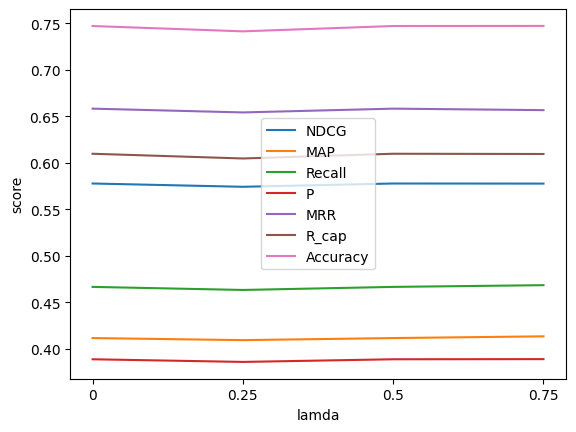

In [5]:
df = get_average_results()
df = get_hyperparam_comparison(df, 'lamda', 'cluster_chunker_mode_k-preserve')
plot_metrics_cross_all_k(df, xargs = ['0', '0.25', '0.5', '0.75'], xlabel = 'lamda')

## min_samples

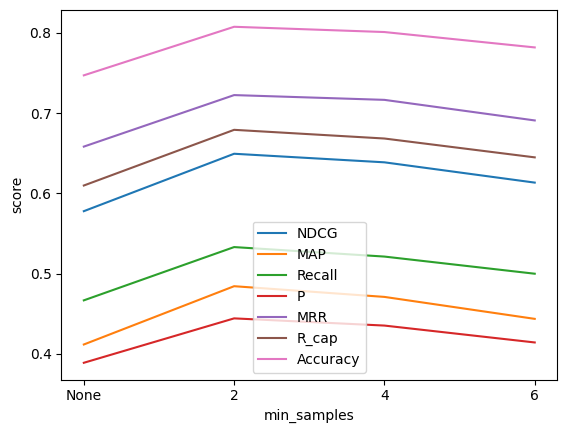

In [6]:
df = get_average_results()
df = get_hyperparam_comparison(df, 'min_samples', 'cluster_chunker_mode_k-preserve')
plot_metrics_cross_all_k(df, xargs = ['None', '2', '4', '6'], xlabel = 'min_samples')

## n_clusters

The configs I use are not representative, considering that each long document consists of 8 short documents.

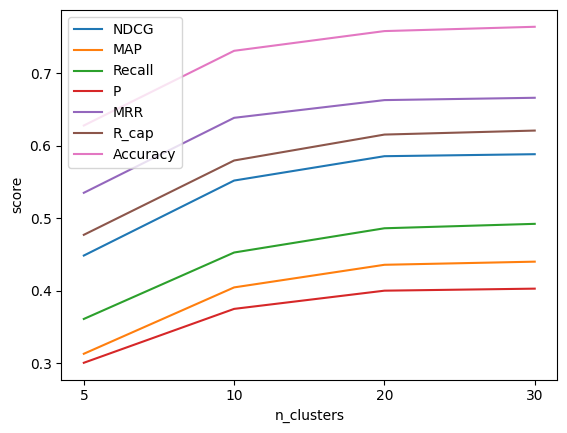

In [7]:
df = get_average_results()
df = get_hyperparam_comparison(df, 'n_clusters', exclude_methods=['cluster_chunker_mode_k-split_n_clusters_5_n_sents_per_segment_3', 'cluster_chunker_mode_k-split_n_clusters_5_n_sents_per_segment_5', 'cluster_chunker_mode_k-split_n_clusters_20_n_sents_per_segment_3'])
df = pd.concat([df.iloc[[-1],:], df.iloc[:-1,:]], axis=1)
plot_metrics_cross_all_k(df, xargs = ['5', '10', '20', '30'], xlabel = 'n_clusters')

## n_sents_per_segment

doc = [a, b, c, d, e, f]
n_sents_per_segment = 2
["ab", "cd", "ef"]
[a, d] [b, e] [c, f]

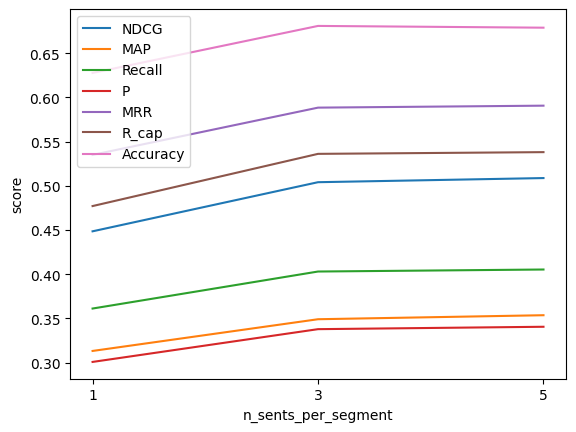

In [8]:
df = get_average_results()
df = get_hyperparam_comparison(df, 'n_sents_per_segment', default_method='cluster_chunker_mode_k-split_n_clusters_5', exclude_methods=['cluster_chunker_mode_k-split_n_clusters_20_n_sents_per_segment_3'])
plot_metrics_cross_all_k(df, xargs = ['1', '3', '5'], xlabel = 'n_sents_per_segment')

# MLDR

In [25]:
get_results_df('mldr').sort_values('NDCG@1', ascending=False)

,NDCG@1,NDCG@3,NDCG@5,NDCG@10,NDCG@100,NDCG@1000,MAP@1,MAP@3,MAP@5,MAP@10,...,Hole@10,Hole@100,Hole@1000,Accuracy@1,Accuracy@3,Accuracy@5,Accuracy@10,Accuracy@100,Accuracy@1000,Latency
cluster_chunker_mode_k-preserve_min_samples_2,0.650,0.62292,0.64347,0.67212,0.72933,0.73799,0.35311,0.51525,0.55951,0.58958,...,0.0,0.0,0.0,0.650,0.788,0.854,0.896,0.984,1.0,10.384447
sentence_chunker_k_3,0.618,0.58103,0.59680,0.63070,0.69882,0.70714,0.32903,0.47169,0.50888,0.53894,...,0.0,0.0,0.0,0.618,0.782,0.824,0.880,0.986,1.0,9.562362
cluster_chunker_mode_k-split_n_clusters_20_n_sents_per_segment_3,0.616,0.59049,0.60642,0.63726,0.70394,0.71256,0.32865,0.48111,0.51682,0.54611,...,0.0,0.0,0.0,0.616,0.800,0.848,0.886,0.988,1.0,10.559913
sentence_chunker_k_1,0.532,0.52530,0.54642,0.57560,0.65397,0.66308,0.28448,0.42350,0.46000,0.48518,...,0.0,0.0,0.0,0.532,0.728,0.788,0.852,0.990,1.0,11.989627
word_chunker_k_10,0.424,0.40996,0.42803,0.46881,0.56303,0.57777,0.22828,0.32438,0.35157,0.37786,...,0.0,0.0,0.0,0.424,0.608,0.674,0.786,0.984,1.0,17.143188
whole_chunker_,0.228,0.18745,0.18870,0.20449,0.28358,0.36042,0.10262,0.13259,0.14022,0.14951,...,0.0,0.0,0.0,0.228,0.334,0.378,0.442,0.764,1.0,2.553179
